In [ ]:
!pip install facenet-pytorch

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import precision_recall_curve, average_precision_score
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from facenet_pytorch import InceptionResnetV1, MTCNN
import torchvision.transforms as transforms

model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

mtcnn = MTCNN(image_size=160, margin=40, device=device)

fallback_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
def extract_embedding(img_path):
    img = Image.open(img_path).convert('RGB')

    face_tensor = mtcnn(img)

    if face_tensor is None:
        face_tensor = fallback_transform(img)

    with torch.no_grad():
        face_tensor = face_tensor.unsqueeze(0).to(device)
        embedding = model(face_tensor)
        embedding = F.normalize(embedding, p=2, dim=1)

    return embedding.cpu().numpy().flatten()

def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2)

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip -q -o '/content/Test Dataset.zip' -d '/content/'

In [ ]:
gallery_ids = ['00', '01', '02', '03', '04', '05', '06']
gallery = {}
gallery_images = {}

print("Building gallery embeddings...")
for person_id in gallery_ids:
    folder_path = f'/content/Test Dataset/{person_id}'
    embeddings = []
    first_img = None

    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        emb = extract_embedding(img_path)
        embeddings.append(emb)
        if first_img is None:
            first_img = Image.open(img_path)

    gallery[person_id] = np.array(embeddings)
    gallery_images[person_id] = first_img

queries_path = '/content/Test Dataset/queries'
query_files = sorted(os.listdir(queries_path))

Building gallery embeddings...


In [ ]:
def attention_score(query_emb, gallery_embs, temperature=1.0):
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])

    exp_sims = np.exp(sims / temperature)
    attention = exp_sims / np.sum(exp_sims)

    S_p = np.sum(attention * sims)

    return S_p, attention, sims

def max_score(query_emb, gallery_embs):
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    return np.max(sims), sims

def avg_score(query_emb, gallery_embs):
    sims = np.array([cosine_similarity(query_emb, g) for g in gallery_embs])
    return np.mean(sims), sims

In [ ]:
THRESHOLD = 0.463

results = []

for query_name in query_files:
    query_path = os.path.join(queries_path, query_name)
    query_emb = extract_embedding(query_path)

    ground_truth = query_name.split('_')[1].split('.')[0]
    is_known = ground_truth in gallery_ids

    scores = {}
    for person_id, gallery_embs in gallery.items():
        S_p, attention, pose_sims = attention_score(query_emb, gallery_embs)
        scores[person_id] = {
            'attention_score': S_p,
            'max_score': np.max(pose_sims),
            'avg_score': np.mean(pose_sims),
            'attention_weights': attention,
            'pose_sims': pose_sims
        }

    predicted = max(scores.keys(), key=lambda p: scores[p]['attention_score'])
    best_score = scores[predicted]['attention_score']

    if best_score < THRESHOLD:
        predicted = '07'

    results.append({
        'query': query_name,
        'ground_truth': ground_truth,
        'is_known': is_known,
        'predicted': predicted,
        'score': best_score,
        'all_scores': {p: s['attention_score'] for p, s in scores.items()},
        'correct_id': (predicted == ground_truth) if is_known else (predicted == '07')
    })

print(f"Processed {len(results)} queries")
print(f"Threshold set to: {THRESHOLD}")

Processed 42 queries
Threshold set to: 0.463


In [ ]:
known_results = [r for r in results if r['is_known']]
unknown_results = [r for r in results if not r['is_known']]

correct_known = sum(1 for r in known_results if r['correct_id'])
total_known = len(known_results)

correct_unknown = sum(1 for r in unknown_results if r['predicted'] == '07')
total_unknown = len(unknown_results)

total_correct = correct_known + correct_unknown
total_queries = len(results)

print("="*70)
print("IDENTIFICATION RESULTS WITH THRESHOLD")
print("="*70)
print(f"Threshold: {THRESHOLD}")
print("="*70)
print(f"Known people (00-06): {correct_known}/{total_known} = {100*correct_known/total_known:.1f}%")
print(f"Unknown people (07): {correct_unknown}/{total_unknown} = {100*correct_unknown/total_unknown:.1f}%")
print(f"Overall Accuracy: {total_correct}/{total_queries} = {100*total_correct/total_queries:.1f}%")
print("="*70)

print("\nDetailed Results (Known):")
for r in known_results:
    status = "✓" if r['correct_id'] else "✗"
    below_thresh = " [BELOW THRESHOLD]" if r['score'] < THRESHOLD else ""
    print(f"{status} {r['query']} → Pred: {r['predicted']}, Truth: {r['ground_truth']}, Score: {r['score']:.3f}{below_thresh}")

print("\nDetailed Results (Unknown - should be predicted as 07):")
for r in unknown_results:
    status = "✓" if r['predicted'] == '07' else "✗"
    below_thresh = " [BELOW THRESHOLD]" if r['score'] < THRESHOLD else ""
    print(f"{status} {r['query']} → Pred: {r['predicted']}, Truth: {r['ground_truth']}, Score: {r['score']:.3f}{below_thresh}")

IDENTIFICATION RESULTS WITH THRESHOLD
Threshold: 0.463
Known people (00-06): 24/29 = 82.8%
Unknown people (07): 13/13 = 100.0%
Overall Accuracy: 37/42 = 88.1%

Detailed Results (Known):
✓ 01_00.jpg → Pred: 00, Truth: 00, Score: 0.643
✓ 04_01.jpg → Pred: 01, Truth: 01, Score: 0.679
✓ 05_02.jpg → Pred: 02, Truth: 02, Score: 0.664
✓ 07_03.jpg → Pred: 03, Truth: 03, Score: 0.682
✓ 08_00.jpg → Pred: 00, Truth: 00, Score: 0.593
✓ 11_03.jpg → Pred: 03, Truth: 03, Score: 0.775
✓ 13_04.jpg → Pred: 04, Truth: 04, Score: 0.557
✗ 16_04.jpg → Pred: 05, Truth: 04, Score: 0.508
✓ 17_03.jpg → Pred: 03, Truth: 03, Score: 0.722
✓ 18_01.jpg → Pred: 01, Truth: 01, Score: 0.628
✓ 19_05.jpg → Pred: 05, Truth: 05, Score: 0.604
✓ 20_00.jpg → Pred: 00, Truth: 00, Score: 0.564
✓ 21_03.jpg → Pred: 03, Truth: 03, Score: 0.620
✓ 22_05.jpg → Pred: 05, Truth: 05, Score: 0.706
✓ 23_00.jpg → Pred: 00, Truth: 00, Score: 0.610
✓ 24_03.jpg → Pred: 03, Truth: 03, Score: 0.539
✓ 26_03.jpg → Pred: 03, Truth: 03, Score: 0.81

Score Statistics:
Known people (00-06):
  Min: 0.243
  Max: 0.818
  Mean: 0.607
  Median: 0.620

Unknown people (07):
  Min: 0.164
  Max: 0.458
  Mean: 0.318
  Median: 0.330


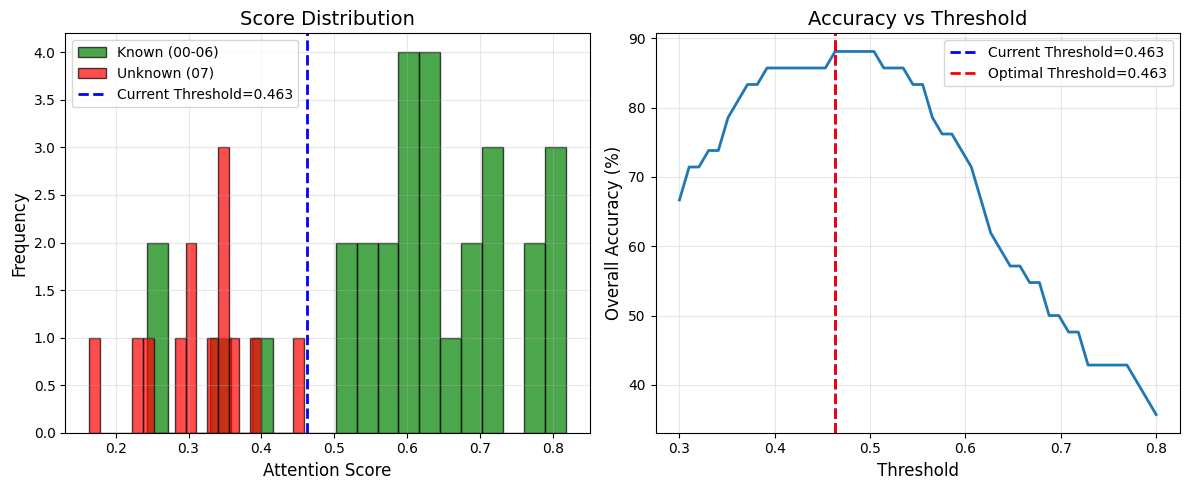


Optimal threshold based on overall accuracy: 0.463
Maximum accuracy achievable: 88.1%


In [ ]:
known_scores = [r['score'] for r in known_results]
unknown_scores = [r['score'] for r in unknown_results]

print("Score Statistics:")
print("="*60)
print(f"Known people (00-06):")
print(f"  Min: {np.min(known_scores):.3f}")
print(f"  Max: {np.max(known_scores):.3f}")
print(f"  Mean: {np.mean(known_scores):.3f}")
print(f"  Median: {np.median(known_scores):.3f}")
print(f"\nUnknown people (07):")
print(f"  Min: {np.min(unknown_scores):.3f}")
print(f"  Max: {np.max(unknown_scores):.3f}")
print(f"  Mean: {np.mean(unknown_scores):.3f}")
print(f"  Median: {np.median(unknown_scores):.3f}")
print("="*60)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(known_scores, bins=20, alpha=0.7, label='Known (00-06)', color='green', edgecolor='black')
plt.hist(unknown_scores, bins=20, alpha=0.7, label='Unknown (07)', color='red', edgecolor='black')
plt.axvline(THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Current Threshold={THRESHOLD}')
plt.xlabel('Attention Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Score Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
test_thresholds = np.linspace(0.3, 0.8, 50)
accuracies = []

for thresh in test_thresholds:
    correct = 0
    for r in results:
        if r['is_known']:
            if r['score'] >= thresh and r['predicted'] == r['ground_truth']:
                correct += 1
            elif r['score'] < thresh:
                pass
        else:
            if r['score'] < thresh:
                correct += 1

    accuracies.append(100 * correct / len(results))

plt.plot(test_thresholds, accuracies, linewidth=2)
plt.axvline(THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Current Threshold={THRESHOLD}')
best_thresh = test_thresholds[np.argmax(accuracies)]
plt.axvline(best_thresh, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold={best_thresh:.3f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Overall Accuracy (%)', fontsize=12)
plt.title('Accuracy vs Threshold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold based on overall accuracy: {best_thresh:.3f}")
print(f"Maximum accuracy achievable: {np.max(accuracies):.1f}%")

In [ ]:
y_true = []
y_scores = []

for r in known_results:
    y_true.append(1 if r['correct_id'] else 0)
    y_scores.append(r['score'])

y_true = np.array(y_true)
y_scores = np.array(y_scores)

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

print(f"Average Precision (AP): {ap:.4f}")

Average Precision (AP): 1.0000


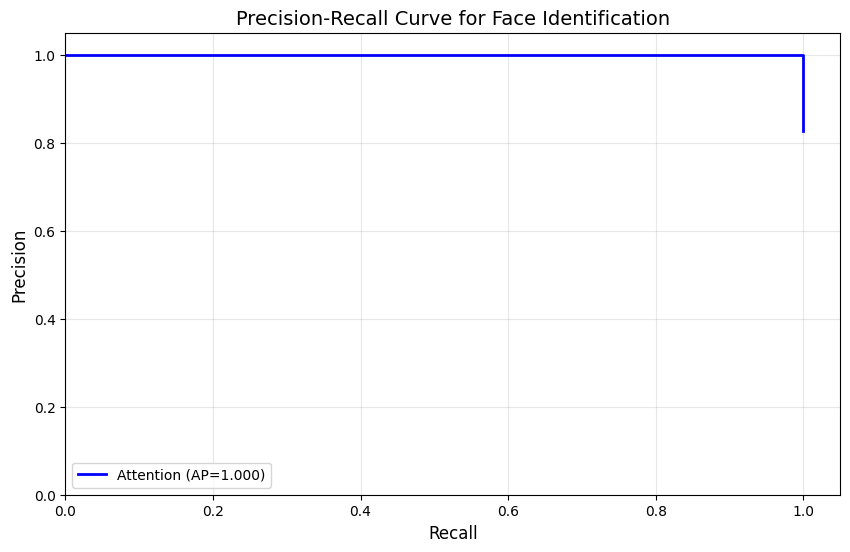

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, 'b-', linewidth=2, label=f'Attention (AP={ap:.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve for Face Identification', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.show()

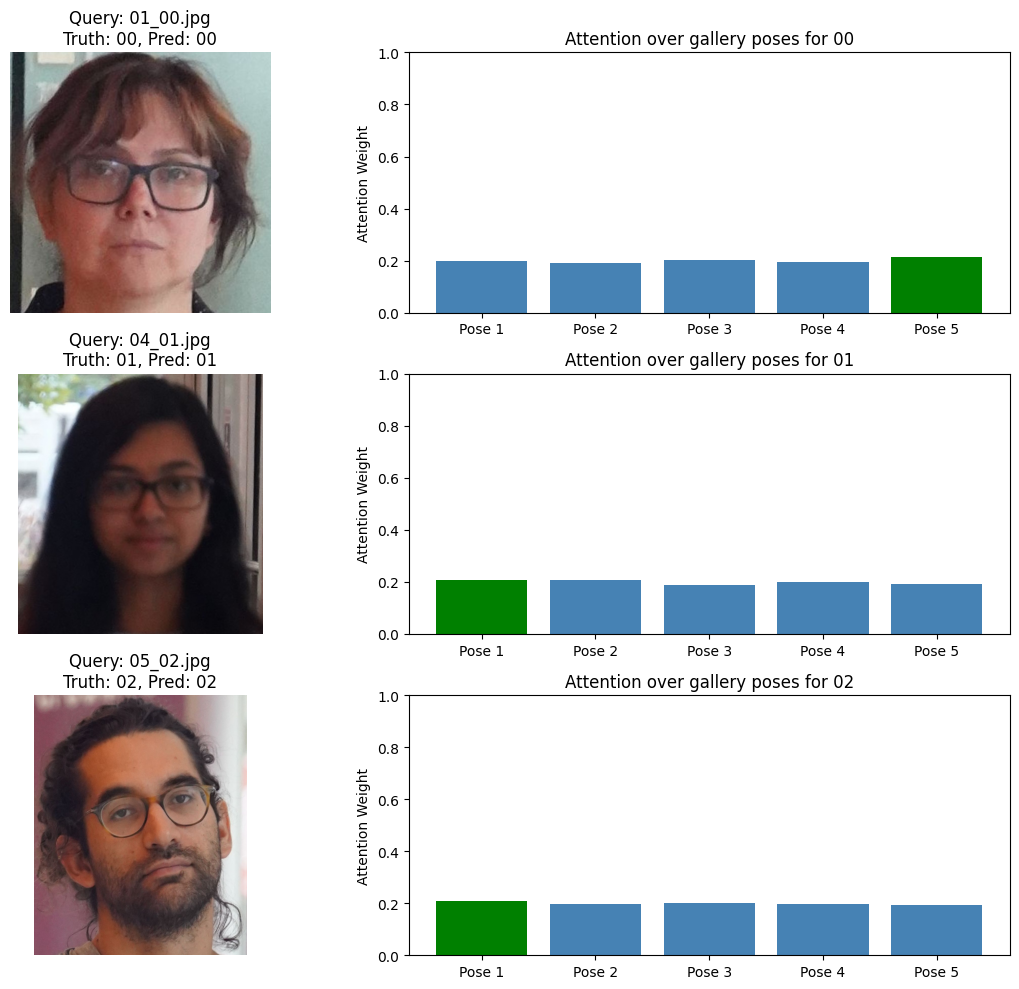

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

sample_queries = [known_results[i] for i in range(min(3, len(known_results)))]

for idx, r in enumerate(sample_queries):
    query_path = os.path.join(queries_path, r['query'])
    query_img = Image.open(query_path)
    query_emb = extract_embedding(query_path)

    pred_id = r['predicted']
    _, attention, pose_sims = attention_score(query_emb, gallery[pred_id])

    axes[idx, 0].imshow(query_img)
    axes[idx, 0].set_title(f"Query: {r['query']}\nTruth: {r['ground_truth']}, Pred: {pred_id}")
    axes[idx, 0].axis('off')

    poses = ['Pose 1', 'Pose 2', 'Pose 3', 'Pose 4', 'Pose 5']
    colors = ['green' if a == max(attention) else 'steelblue' for a in attention]
    axes[idx, 1].bar(poses, attention, color=colors)
    axes[idx, 1].set_ylabel('Attention Weight')
    axes[idx, 1].set_title(f'Attention over gallery poses for {pred_id}')
    axes[idx, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()